# Scoring Elaticsearch Results
### LMI Capstone Team
### Summer Chambers | Steve Morris | Kaleb Shikur

## Setup

In [1]:
import pandas as pd
import numpy as np
import json
import math
from statistics import mode
from sklearn.metrics import ndcg_score, f1_score, average_precision_score
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
metadata_url = "https://mikeanders.org/data/CMS/CMS-2018-0101-0001/CMS-1701-P%20Comment%20MetaData.csv"
data = pd.read_csv(metadata_url, usecols=range(0,36))[:468] #ignore last few columns and blank rows at end of csv 
data = data.rename(columns=lambda x: x.strip()) #strip whitespace from columns

In [3]:
data10 = data.fillna(0) #fill NaN with 0

section_cols = data10.columns[3:] 
data10[section_cols] = data10[section_cols].replace(["Y"], 1) #replace Y with 1 in approriate columns
data11 = data10.copy()
section_cols1  = data11.columns[3:] 
data11[section_cols1] = np.where((data11[section_cols1]  != 1), 0, data11[section_cols1])

# Combining columns for index matching: (A6b, A6b.1, = A6b),  (C3b, C3b.1'= C3b) ('A7', 'A7.1', 'A7.2', = A7b, a7c),  (F = F2, F3)

data11['A6b'] = (data11['A6b'] + data11['A6b.1'])
data11['A6b'] = data11['A6b'].replace(2,1)
data11['C3b'] = (data11['C3b'] + data11['C3b.1'])
data11['C3b'] = data11['C3b'].replace(2,1)
data11['A7'] = (data11['A7'] + data11['A7.1'] + data11['A7.2'])
data11['A7'] = data11['A7'].replace(2,1)
data11['A7'] = data11['A7'].replace(3,1)

data11 = data11.drop(['A6b.1', 'C3b.1', 'A7.1', 'A7.2'], axis=1)
data11.Name = [name.split('DRAFT-')[1].split('-')[0] for name in data11.Name]
data11 = data11.rename(columns=lambda x: x.lower())
section_cols1 = data11.columns[3:]

In [4]:
data11

,name,organization name / submitter name,submitter state,a2,a3,a4b,a4c,a5b,a5c,a5d,...,d3c,d3d,d4,e2,e3,e4,e5,e6,e7,f
0,0002,Erick Meleher,NC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0003,Mayank Shah,IL,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,0004,Mayank Shah,IL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0005,Morey Menacker,NJ,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0006,Todd Rapoza,MA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463,0465,Morehouse Choice Accountable Care Organization...,GA,1,1,0,0,1,0,1,...,1,0,0,0,0,0,0,1,0,0
464,0466,Liberty ACO,TX,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
465,0467,Washington State Hospital Association,WA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466,0468,Think Whole Person Healthcare,NE,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
truth_dict = {} # initiate dict
for i, name in enumerate(data11.name): # iterate through Comment Names
    dict1 = {col:data11[col].iloc[i] for col in section_cols1} # locate this row's values for each column
    list1 = [key for key,value in dict1.items() if value==1] # create list of matching sections for this row
    truth_dict[name] = list1 # add Comment Name and list of matching sections to dict

In [6]:
with open("unique_comments2018.json") as f:
    unique_comments2018 = json.load(f)

In [7]:
unique_data = data11.loc[data11['name'].isin(unique_comments2018.keys())]

In [8]:
unique_truth_dict = {} # initiate dict
for i, name in enumerate(unique_data.name): # iterate through Comment Names
    dict1 = {col:unique_data[col].iloc[i] for col in section_cols1} # locate this row's values for each column
    list1 = [key for key,value in dict1.items() if value==1] # create list of matching sections for this row
    unique_truth_dict[name] = list1 # add Comment Name and list of matching sections to dict

In [9]:
#define true rule section names
truth_keys = list(section_cols1)
truth_keys = [key1.lower() for key1 in truth_keys]

In [10]:
data11.sum()[2:]

a2      109
a3      153
a4b      19
a4c     109
a5b      86
a5c      50
a5d      38
a6b      21
a6c      20
a6d2      5
a6d3     18
a7       51
b2a     116
b2b      83
c2      119
c3a      95
c3b      56
d2      140
d3b      81
d3c      54
d3d       9
d4        3
e2      219
e3       28
e4       18
e5       74
e6       59
e7       25
f         6
dtype: object

## Headers Standard Index Testing

In [11]:
with open('match_header_results.json') as f:
    unique_header_results = json.load(f)

In [12]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in unique_header_results.items(): #iterate through json results
    value_list = []
    for val_idx, score in value.items(): #iterate through one query's results
        for true_key in truth_keys: #iterate through names of true keys
            if true_key in val_idx and true_key not in value_list: #add true key names to list of results, maintaining order 
                value_list.append(true_key)
        unique_header_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)} #keep scores

### Normalize scores (divide by mean score of each query result)

In [13]:
normalized_results = {}
for comment_idx, result in unique_header_results.items(): #iterate through results
    score_mean = np.mean(list(result.values())) #get mean of scores
    score_dict = {}
    for rule_idx, score in result.items(): #iterate through scores in one result
        score_dict[rule_idx] = score/score_mean #normalize score
    normalized_results[comment_idx] = score_dict

### Make scores a list of tuples rather than dictionar key/values, to avoid problems with uniqueness later

In [14]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for comment chunks that came from the same comment

In [15]:
merged_results = {}
for key in unique_truth_dict.keys(): #for true comment names (0013, 0014, etc.)
    merged_list = []
    for comment_idx, result_list in normalized_lists.items(): #for each result
        if key in comment_idx:
            merged_list.extend(result_list) #add all returned rule sections to mergeable list
    merged_results[key] = merged_list
#sort by highest scores
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [16]:
for comment_idx, tup_list in merged_results.items(): #for each result
    score_dict = {}
    for tup in tup_list: #for each tuple
        if tup[0] in score_dict.keys(): #if the rule section is already in list,
            score_dict[tup[0]] += tup[1] #merge rule section names but add scores together
        else: #if not already in list
            score_dict[tup[0]] = tup[1] #put score in dict
    merged_results[comment_idx] = score_dict

In [17]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()} #sort by highest scores

In [18]:
merged_results_threshold = {comment_idx:{rule_sect: score for rule_sect, score in value.items() if score > 1.5} \
                            for comment_idx, value, in merged_results.items()}

### Scoring

In [19]:
merged_result_lists = {key:list(value.keys()) for key, value in merged_results.items()}

In [20]:
from ml_metrics import mapk
ap_results = {}
for (key, truth) in unique_truth_dict.items():
    k = len(truth)
    ap_results[key] = {"k": k, "ap": mapk(k=k, actual=truth, predicted=list(merged_results[key]))}

C:\Users\steph\anaconda3\envs\python385\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\steph\anaconda3\envs\python385\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [21]:
np.mean([value["ap"] for key, value in ap_results.items() if value["k"] != 0])

0.3463858351402018

In [22]:
unique_truth_dict_all = unique_truth_dict.copy()   #make a copy of the truth dictionary
for key, value in unique_truth_dict.items(): #for true key/val pair in dictionary
    new_value_list = np.zeros(len(truth_keys)) #make array of zeros, of length 29 (29 rule sections)
    for val in value: #for each rule section
        for i in range(len(truth_keys)): #for each of 29 spots in array
            if val == truth_keys[i]: #if rule section in current array index,
                new_value_list[i] = 1 #set to 1, else 0
    unique_truth_dict_all[key] = new_value_list

In [23]:
#create header results dict with values equal to sparse array length=29, (discounted and binary versions)
unique_header_results_all = merged_results.copy() #make copy of results
unique_binary_header_results_all = merged_results.copy() #make copy of results
for key, value in merged_results.items(): #for each comment
    new_value_list_discounted = np.zeros(len(truth_keys)) #make array of zeros, of length 29 (29 rule sections)
    new_value_list_binary = np.zeros(len(truth_keys)) #make array of zeros, of length 29 (29 rule sections)
    counter = 1 #initiate counter for a query result at 1
    for rule_section in value.keys(): #go through all rule sections in query
        for i in range(len(truth_keys)): #for each of 29 spots in array
            if rule_section == truth_keys[i]: #if rule section in current array index
                counter += 1 #add to counter
                #assign value to 1 for first rule section, but penalize lower scored rule sections with scores progressively lower than one
                new_value_list_discounted[i] = 1/math.log(counter, 2) 
                new_value_list_binary[i] = 1 #binary means we lose the order ES returned rules in, just weights all sections equally
    unique_header_results_all[key] = new_value_list_discounted
    unique_binary_header_results_all[key] = new_value_list_binary

In [24]:
unique_headers_ndcg = {}
unique_headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_header_results_all.items()):
    unique_headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_binary_header_results_all.items()):
    unique_headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0)

In [25]:
unique_headers_eval = pd.DataFrame(data=[unique_headers_ndcg, unique_headers_f1]).T
unique_headers_eval = unique_headers_eval.rename({0:"NDCG", 1:"F1"}, axis=1)

In [26]:
unique_headers_eval.describe()

,NDCG,F1
count,94.000000,94.000000
mean,0.566270,0.341308
std,0.243063,0.232241
min,0.000000,0.000000
25%,0.435279,0.181818
50%,0.549032,0.320513
75%,0.754886,0.494048
max,0.998650,0.897959


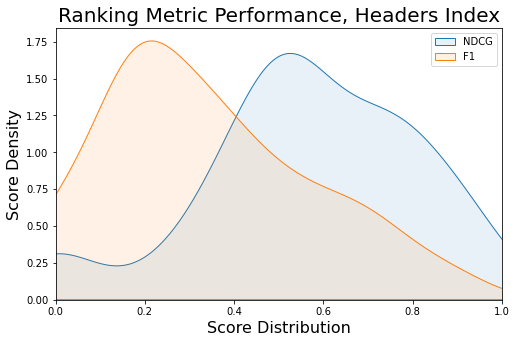

In [27]:
plt.figure(figsize = (8,5))
sns.kdeplot(unique_headers_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(unique_headers_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Headers Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

### Which comments were scored poorly?

In [28]:
with open('expanded.json') as f1:
    comments = json.load(f1)

In [29]:
unique_headers_eval.query("NDCG == 0")

,NDCG,F1
0110,0.0,0.0
0126,0.0,0.0
0240,0.0,0.0
0256,0.0,0.0
0287,0.0,0.0
0408,0.0,0.0
0467,0.0,0.0


In [30]:
poorf1 = unique_headers_eval.query("F1 < 0.5").F1
poorf1

0002    0.000000
0003    0.125000
0004    0.181818
0005    0.181818
0006    0.000000
          ...   
0419    0.166667
0428    0.333333
0437    0.333333
0438    0.333333
0467    0.000000
Name: F1, Length: 70, dtype: float64

In [31]:
poorndcg = unique_headers_eval.query("NDCG < 0.3").NDCG
poorndcg

0002    0.23243
0006    0.23243
0110    0.00000
0126    0.00000
0211    0.23243
0240    0.00000
0256    0.00000
0287    0.00000
0408    0.00000
0467    0.00000
Name: NDCG, dtype: float64

In [32]:
poorf1_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorf1}
poorf1_comments_truth

{'0002': ['d2'],
 '0003': ['d2', 'd3c', 'e5'],
 '0004': ['a7'],
 '0005': ['a5b'],
 '0006': ['f'],
 '0007': ['e3'],
 '0008': ['c3b'],
 '0009': ['a5b'],
 '0010': ['a3', 'a5b'],
 '0011': ['a3', 'a5b'],
 '0014': ['a2', 'a3', 'a4c', 'c3a', 'd2', 'd3b', 'd3c', 'e6'],
 '0016': ['e5'],
 '0042': ['a5c'],
 '0077': ['e6', 'f'],
 '0081': ['a2', 'a4c', 'd2', 'e2'],
 '0110': [],
 '0115': ['e2'],
 '0126': [],
 '0138': ['a3', 'a5b'],
 '0157': ['a4c', 'e2'],
 '0170': ['a2',
  'a3',
  'a5b',
  'a5d',
  'a6d2',
  'a7',
  'c2',
  'c3a',
  'c3b',
  'd2',
  'd3c',
  'e2',
  'e5'],
 '0172': ['a2', 'a4c', 'b2a', 'c2', 'c3a', 'd2'],
 '0189': ['e6'],
 '0190': ['c2', 'e5', 'e6'],
 '0191': ['a7'],
 '0195': ['c3a', 'e5'],
 '0205': ['b2b'],
 '0207': ['a3', 'a4c', 'b2a', 'c3a', 'd2', 'e2', 'e3'],
 '0211': ['a2'],
 '0221': ['a3', 'a5d'],
 '0222': ['a6c'],
 '0226': ['a5b', 'a7'],
 '0229': ['a2', 'a3', 'a5b', 'a6c', 'b2a', 'b2b', 'c2', 'c3a', 'd2', 'd3b'],
 '0233': ['a3'],
 '0234': ['e5', 'e7'],
 '0239': ['a2', 'e5'],


In [33]:
poorndcg_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorndcg}
poorndcg_comments_truth

{'0002': ['d2'],
 '0006': ['f'],
 '0110': [],
 '0126': [],
 '0211': ['a2'],
 '0240': [],
 '0256': [],
 '0287': [],
 '0408': [],
 '0467': []}

## Hybrid Standard Index Testing

In [34]:
with open('match_hybrid_results.json') as f1:
    unique_hybrid_results = json.load(f1)

In [35]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in unique_hybrid_results.items():
    value_list = []
    for val_idx in value:
        for true_key in truth_keys:
            if true_key in val_idx[0:4]:
                    value_list.append(true_key)
        unique_hybrid_results[key]=[(true_key, score) for (val_idx, score), true_key in zip(value.items(),value_list)]

In [36]:
for comment_idx, tup_list in unique_hybrid_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    unique_hybrid_results[comment_idx] = score_dict

### Normalize scores (divide by mean)

In [37]:
normalized_results = {}
for comment_idx, result in unique_hybrid_results.items():
    score_mean = np.mean(list(result.values()))
    score_dict = {}
    for rule_idx, score in result.items():
        score_dict[rule_idx] = score/score_mean
    normalized_results[comment_idx] = score_dict

In [38]:
normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}

### Merge results for same comment chunks

In [39]:
merged_results = {}
for key in unique_truth_dict.keys():
    merged_list = []
    for comment_idx, result_list in normalized_lists.items():
        if key in comment_idx:
            merged_list.extend(result_list)
    merged_results[key] = merged_list
merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}

In [40]:
for comment_idx, tup_list in merged_results.items():
    score_dict = {}
    for tup in tup_list:
        if tup[0] in score_dict.keys():
            score_dict[tup[0]] += tup[1]
        else:
            score_dict[tup[0]] = tup[1]
    merged_results[comment_idx] = score_dict

In [41]:
merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True))\
                  for comment_idx, result in merged_results.items()}

### Sklearn

In [42]:
unique_truth_dict_all = unique_truth_dict.copy()   #make a copy of the truth dictionary
for key, value in unique_truth_dict.items(): #for true key/val pair in dictionary
    new_value_list = np.zeros(len(truth_keys)) #make array of zeros, of length 29 (29 rule sections)
    for val in value: #for each rule section
        for i in range(len(truth_keys)): #for each of 29 spots in array
            if val == truth_keys[i]: #if rule section in current array index,
                new_value_list[i] = 1 #set to 1, else 0
    unique_truth_dict_all[key] = new_value_list

In [43]:
#create hybrid results dict with values equal to sparse array length=29, (discounted and binary versions)
unique_hybrid_results_all = merged_results.copy() #make copy of results
unique_binary_hybrid_results_all = merged_results.copy() #make copy of results
for key, value in merged_results.items(): #for each comment
    new_value_list_discounted = np.zeros(len(truth_keys)) #make array of zeros, of length 29 (29 rule sections)
    new_value_list_binary = np.zeros(len(truth_keys)) #make array of zeros, of length 29 (29 rule sections)
    counter = 1 #initiate counter for a query result at 1
    for rule_section in value.keys(): #go through all rule sections in query
        for i in range(len(truth_keys)): #for each of 29 spots in array
            if rule_section == truth_keys[i]: #if rule section in current array index
                counter += 1 #add to counter
                #assign value to 1 for first rule section, but penalize lower scored rule sections with scores progressively lower than one
                new_value_list_discounted[i] = 1/math.log(counter, 2) 
                new_value_list_binary[i] = 1 #binary means we lose the order ES returned rules in, just weights all sections equally
    unique_hybrid_results_all[key] = new_value_list_discounted
    unique_binary_hybrid_results_all[key] = new_value_list_binary

In [44]:
unique_hybrid_ndcg = {}
unique_hybrid_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_hybrid_results_all.items()):
    unique_hybrid_ndcg[true_key] = ndcg_score([true_value], [es_value])
for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), unique_binary_hybrid_results_all.items()):
    unique_hybrid_f1[true_key] = f1_score(true_value, es_value, zero_division=0)

In [45]:
unique_hybrid_eval = pd.DataFrame(data=[unique_hybrid_ndcg, unique_hybrid_f1]).T
unique_hybrid_eval = unique_hybrid_eval.rename({0:"NDCG", 1:"F1"}, axis=1)

In [46]:
unique_hybrid_eval.describe()

,NDCG,F1
count,94.000000,94.000000
mean,0.561436,0.326001
std,0.261366,0.227458
min,0.000000,0.000000
25%,0.426921,0.181818
50%,0.562672,0.333333
75%,0.769505,0.440476
max,1.000000,0.880000


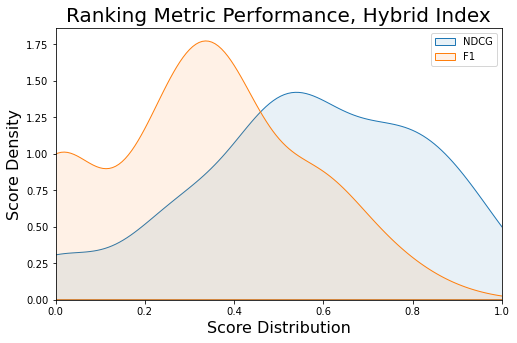

In [47]:
plt.figure(figsize = (8,5))
sns.kdeplot(unique_hybrid_eval.NDCG, alpha=.1, shade=True, label='NDCG')
sns.kdeplot(unique_hybrid_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Hybrid Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

### Which comments were scored poorly?

In [48]:
with open('expanded.json') as f1:
    comments = json.load(f1)

In [49]:
unique_hybrid_eval.query("NDCG == 0")

,NDCG,F1
0110,0.0,0.0
0126,0.0,0.0
0240,0.0,0.0
0256,0.0,0.0
0287,0.0,0.0
0408,0.0,0.0
0467,0.0,0.0


In [50]:
poorf1 = unique_hybrid_eval.query("F1 < 0.5").F1
#poorf1

In [51]:
poorndcg = unique_hybrid_eval.query("NDCG < 0.3").NDCG
#poorndcg

In [52]:
poorf1_comments = {key:comment for key, comment in comments.items() if key[0:4] in poorf1}
#{key:len(comment) for key, comment in poorf1_comments.items()}

In [53]:
poorf1_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorf1}
#poorf1_comments_truth

In [54]:
poorndcg_comments = {key:comment for key, comment in comments.items() if key in poorndcg}
#{key:len(comment) for key, comment in poorndcg_comments.items()}

In [55]:
poorndcg_comments_truth = {key:matches for key, matches in truth_dict.items() if key in poorndcg}
#poorndcg_comments_truth

## Compare different indices

In [56]:
df_list = [unique_headers_eval, unique_hybrid_eval]
mean_df_list = [df.mean() for df in df_list]

In [57]:
comparison = pd.DataFrame(mean_df_list).T.rename({i:df for i, df in enumerate(["Std Hdr", "Std Hyb", "Cst Hyb"])}, axis=1)
comparison

,Std Hdr,Std Hyb
NDCG,0.566270,0.561436
F1,0.341308,0.326001


# Defining a Score_Results Function

In [58]:
#Kaleb's MAP Function
def Map_estimator(tru, pred): 
    precision = []
    for x,y in zip(tru,pred):
        wow = 0
        counter = 0
        for i, z in enumerate(y):
            if z in x:
                counter += 1
                wow += 1/(i+1)
            if i >= 1 + len(x):
                break;
        precision.append(wow/(counter+0.0001))
    return np.mean(precision)

In [59]:
def score_results(json_file, index_type): #takes .json result and "headers"/"hybrid" as input, gives pandas eval df and map as output
    #open file
    with open(json_file) as f:
        custom_results = json.load(f)
    
    if index_type == "hybrid":
        #tranlate ES keys to true rule section names, MAINTAINING ORDER
        for key, value in custom_results.items():
            value_list = []
            for val_idx in value:
                for true_key in truth_keys:
                    if true_key in val_idx[0:4]:
                            value_list.append(true_key)
                custom_results[key]=[(true_key, score) for (val_idx, score), true_key in zip(value.items(),value_list)]
        for comment_idx, tup_list in custom_results.items():
            score_dict = {}
            for tup in tup_list:
                if tup[0] in score_dict.keys():
                    score_dict[tup[0]] += tup[1]
                else:
                    score_dict[tup[0]] = tup[1]
            custom_results[comment_idx] = score_dict
    
    elif index_type == "headers": 
        #tranlate ES keys to true rule section names, MAINTAINING ORDER
        for key, value in custom_results.items():
            value_list = []
            for val_idx, score in value.items():
                for true_key in truth_keys:
                    if true_key in val_idx and true_key not in value_list: 
                        value_list.append(true_key)
                custom_results[key]={true_key: score for (val_idx, score), true_key in zip(value.items(),value_list)}     
    
    #Normalize results by dividing by mean
    normalized_results = {}
    for comment_idx, result in custom_results.items():
        score_mean = np.mean(list(result.values()))
        score_dict = {}
        for rule_idx, score in result.items():
            score_dict[rule_idx] = score/score_mean
        normalized_results[comment_idx] = score_dict
    normalized_lists = {comment_idx:list(score_dict.items()) for comment_idx, score_dict in normalized_results.items()}
    
    #Merge results back together
    merged_results = {}
    for key in unique_truth_dict.keys():
        merged_list = []
        for comment_idx, result_list in normalized_lists.items():
            if key in comment_idx:
                merged_list.extend(result_list)
        merged_results[key] = merged_list
    merged_results = {comment_idx:sorted(result, key=lambda x:x[1], reverse=True) for comment_idx, result in merged_results.items()}
    for comment_idx, tup_list in merged_results.items():
        score_dict = {}
        for tup in tup_list:
            if tup[0] in score_dict.keys():
                score_dict[tup[0]] += tup[1]
            else:
                score_dict[tup[0]] = tup[1]
        merged_results[comment_idx] = score_dict
    merged_results = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True)) for comment_idx, result in merged_results.items()}
    
    #Remove frequently returned rule sections (in >80% of results)
    all_sections = []
    for key, result in merged_results.items():
        all_sections.extend(section for section in result)
    counts = {}
    for key in truth_keys:
        key_count = all_sections.count(key)
        counts[key] = key_count
    tb_removed = [section for section, count in counts.items() if count > (.8*len([len(value) for value in unique_truth_dict.values()]))]
    
    def comm_removed(merged_dict, tb_removed):
        new_merged = {}
        for com_id, x in merged_dict.items():
            results = {}
            for key, value in x.items():
                if key not in tb_removed:
                    results[key] = value 
                elif key in tb_removed:
                    results[key] = value*.25
                new_merged[com_id] = results
        return new_merged
    
    clean_merged = comm_removed(merged_results, tb_removed)
    clean_merged = {comment_idx:dict(sorted(result.items(), key = lambda x:x[1], reverse=True)) for comment_idx, result in clean_merged.items()}
    
    #create truth dict with values equal to sparse array length=29, binary
    unique_truth_dict_all = unique_truth_dict.copy()   #make a copy of the truth dictionary
    for key, value in unique_truth_dict.items(): #for true key/val pair in dictionary
        new_value_list = np.zeros(len(truth_keys)) #make array of zeros, of length 29 (29 rule sections)
        for val in value: #for each rule section
            for i in range(len(truth_keys)): #for each of 29 spots in array
                if val == truth_keys[i]: #if rule section in current array index,
                    new_value_list[i] = 1 #set to 1, else 0
        unique_truth_dict_all[key] = new_value_list
    
    #create header results dict with values equal to sparse array length=29, (discounted and binary versions)
    custom_results_all = clean_merged.copy() #make copy of results
    custom_binary_results_all = clean_merged.copy() #make copy of results
    for key, value in clean_merged.items(): #for each comment
        new_value_list_discounted = np.zeros(len(truth_keys)) #make array of zeros, of length 29 (29 rule sections)
        new_value_list_binary = np.zeros(len(truth_keys)) #make array of zeros, of length 29 (29 rule sections)
        counter = 1 #initiate counter for a query result at 1
        for rule_section in value.keys(): #go through all rule sections in query
            for i in range(len(truth_keys)): #for each of 29 spots in array
                if rule_section == truth_keys[i]: #if rule section in current array index
                    counter += 1 #add to counter
                    #assign value to 1 for first rule section, but penalize lower scored rule sections with scores progressively lower than one
                    new_value_list_discounted[i] = 1/math.log(counter, 2) 
                    new_value_list_binary[i] = 1 #binary means we lose the order ES returned rules in, just weights all sections equally
        custom_results_all[key] = new_value_list_discounted
        custom_binary_results_all[key] = new_value_list_binary
    
    #Get NDCG, F1 with SKlearn
    custom_ndcg = {}
    custom_f1 = {}
    for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_results_all.items()):
        custom_ndcg[true_key] = ndcg_score([true_value], [es_value])
    for (true_key, true_value), (es_key, es_value) in zip(unique_truth_dict_all.items(), custom_binary_results_all.items()):
        custom_f1[true_key] = f1_score(true_value, es_value, zero_division=0)
    df_eval = pd.DataFrame(data=[custom_ndcg, custom_f1]).T
    df_eval = df_eval.rename({0:"NDCG", 1:"F1"}, axis=1)
    
    ap_results = Map_estimator(list(unique_truth_dict.values()), list(clean_merged.values()))
    
    return df_eval, ap_results

# Grid Search

In [60]:
headers_narrowsyn_basestop_eval, headers_narrowsyn_basestop_map = score_results('headers_narrowsyn_basestop_results.json', "headers")

In [61]:
headers_narrowsyn_custstop_eval, headers_narrowsyn_custstop_map = score_results('headers_narrowsyn_custstop_results.json', "headers")

In [62]:
headers_nosyn_custstop_eval, headers_nosyn_custstop_map = score_results('headers_nosyn_custstop_results.json', "headers")

In [63]:
headers_expsyn_basestop_eval, headers_expsyn_basestop_map = score_results('headers_expsyn_basestop_results.json', "headers")

In [64]:
headers_expsyn_customstop_eval, headers_expsyn_customstop_map = score_results('headers_expsyn_customstop_results.json', "headers")

In [65]:
headers_broadsyn_basestop_eval, headers_broadsyn_basestop_map = score_results('headers_broadsyn_basestop_results.json', "headers")

In [66]:
headers_broadsyn_custstop_eval, headers_broadsyn_custstop_map = score_results('headers_broadsyn_custstop.json', "headers")

In [67]:
headers_nosyn_basestop_eval, headers_nosyn_basestop_map = score_results('headers_nosyn_basestop_results.json', "headers")

In [68]:
headers_expsyn_comsyn_basestop_eval, headers_expsyn_comsyn_basestop_map = score_results('headers_expsyn_comsyn_basestop_results.json',\
                                                                                                "headers")

In [69]:
# headers_expsyn_comsyn_customstop_results
headers_expsyn_comsyn_customstop_eval, headers_expsyn_comsyn_customstop_map = score_results('headers_expsyn_comsyn_customstop_results.json',\
                                                                                                "headers")

In [70]:
headers_narrowsyn_comsyn_customstop_eval, headers_narrowsyn_comsyn_customstop_map = score_results('headers_narrowsyn_comsyn_customstop_results.json',\
                                                                                                "headers")

## Updated: "Grid Search" Compare different indices

In [71]:
df_list = [headers_narrowsyn_basestop_eval, headers_narrowsyn_custstop_eval, headers_nosyn_custstop_eval, \
           headers_expsyn_basestop_eval, headers_expsyn_customstop_eval, headers_broadsyn_basestop_eval, \
          headers_broadsyn_custstop_eval, headers_nosyn_basestop_eval, headers_expsyn_comsyn_basestop_eval, \
          headers_expsyn_comsyn_customstop_eval, headers_narrowsyn_comsyn_customstop_eval]
mean_df_list = [df.mean() for df in df_list]

In [72]:
comparison = pd.DataFrame(mean_df_list).T.rename({i:df for i, df in enumerate(["Narrow-Base", "Narrow-Cust", \
                                                                               "No-Cust", "Exp-Base", "Exp-Cust", \
                                                                              "Broad-Base", "Broad-Cust", "No-Base", "Exp-Comment-Base", \
                                                                               "expsyn_comsyn_custom", "headers_narrowsyn_comsyn_custom"] \
                                                                             )},axis=1)
comparison = comparison.T

In [73]:
aps = [headers_narrowsyn_basestop_map, headers_narrowsyn_custstop_map, headers_nosyn_custstop_map, \
           headers_expsyn_basestop_map, headers_expsyn_customstop_map, headers_broadsyn_basestop_map, \
          headers_broadsyn_custstop_map, headers_nosyn_basestop_map, headers_expsyn_comsyn_basestop_map, \
      headers_expsyn_comsyn_customstop_map, headers_narrowsyn_comsyn_customstop_map]

comparison["MAP"] = [ap for ap in aps]
comparison = comparison.T
print(comparison.columns[np.argmax(comparison.T.NDCG)])

Narrow-Cust


In [74]:
comparison

,Narrow-Base,Narrow-Cust,No-Cust,Exp-Base,Exp-Cust,Broad-Base,Broad-Cust,No-Base,Exp-Comment-Base,expsyn_comsyn_custom,headers_narrowsyn_comsyn_custom
NDCG,0.667177,0.667829,0.667161,0.638062,0.640346,0.648790,0.621920,0.665273,0.658041,0.616523,0.647295
F1,0.345105,0.343939,0.350136,0.343102,0.343279,0.345555,0.343171,0.348243,0.340701,0.336588,0.343253
MAP,0.391329,0.391374,0.407994,0.341184,0.346058,0.367893,0.332645,0.405974,0.390013,0.312599,0.363061


In [75]:
narrow_cust_10_results = score_results('headers_narrowsyn_custstop_results.json', "headers")

In [76]:
narrow_cust_10_results[0].mean()

NDCG    0.667829
F1      0.343939
dtype: float64

In [77]:
narrow_cust_10_results[1]

0.3913736060333647

In [78]:
score_results('hybrid_narrowsyn_custstop.json', "hybrid")[1]

0.4341221102082787

In [168]:
score_df = comparison.copy().T
score_df.drop(score_df.tail(3).index,inplace=True)
score_df = pd.melt(score_df.reset_index(), id_vars=['index'], value_vars=['NDCG', 'F1', 'MAP']).sort_values(['index','variable'])
score_df

,index,variable,value
13,Broad-Base,F1,0.345555
21,Broad-Base,MAP,0.367893
5,Broad-Base,NDCG,0.648790
14,Broad-Cust,F1,0.343171
22,Broad-Cust,MAP,0.332645
6,Broad-Cust,NDCG,0.621920
11,Exp-Base,F1,0.343102
19,Exp-Base,MAP,0.341184
3,Exp-Base,NDCG,0.638062
12,Exp-Cust,F1,0.343279


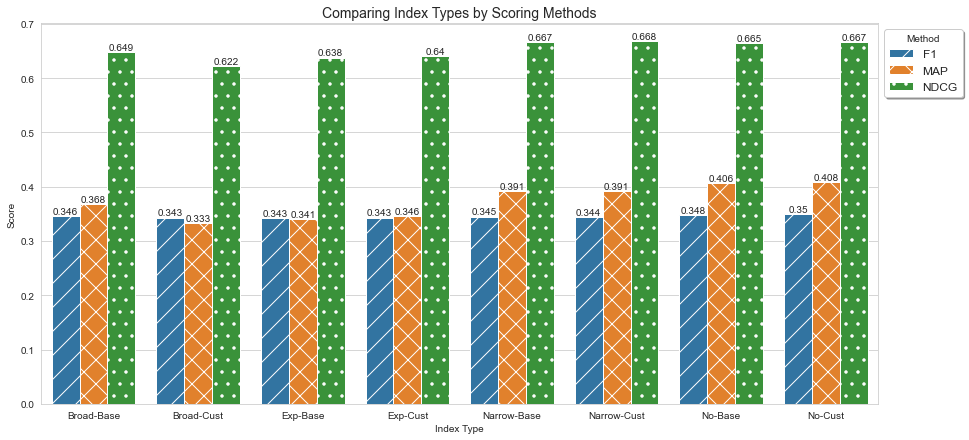

In [236]:
import itertools

sns.set_style('whitegrid')
plt.figure(figsize=(15,7))
barplot=sns.barplot(x='index', y='value', hue='variable', data = score_df)
plt.xlabel('Index Type')
plt.ylabel('Score')
plt.title('Comparing Index Types by Scoring Methods',fontsize=14)
for rect in barplot.patches:
    xcoor=rect.get_x()+.5*rect.get_width()
    ycoor=rect.get_height()
    plt.text(xcoor,ycoor,str(round(float(ycoor),3)),
            horizontalalignment='center',
            verticalalignment='bottom',
            fontsize=10)
# num_locs=len(score_df.variable.unique())
hatches=itertools.cycle([  '/', 'x', '.'])
for i, bar in enumerate(barplot.patches):
    if i%8==0:
        hatch=next(hatches)
    bar.set_hatch(hatch)
plt.legend(title='Method', bbox_to_anchor=(1,1), fontsize=12,shadow=True);